In [1]:
import torch
import torch.nn as nn
from utils import create_bbox_mask
from torch.utils.data import DataLoader
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
from data_loader.data_loaders import CocoDataset, collate_fn
from model.model import *

BATCH_SIZE = 32
seed = 42
torch.manual_seed(seed)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
model = FeatureSynthesisModel()
model = model.to(device)
model.load_state_dict(torch.load('saved/models/masking_l2norm/0829_172712/checkpoint-epoch50.pth')['state_dict'])
backbone_model = ResNet50()

model.eval()  # set to evaluation mode
backbone_model = backbone_model.to(device)
backbone_model.eval()  # set to evaluation mode






cuda:1


/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [2]:
train_set = CocoDataset(root='./data/coco', mode='val2017', transform=transforms, category_embed='one-hot')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)
# test = next(iter(train_loader))
# imgs, canvas_queries, queries = test
# imgs = imgs.to(device)
# canvas_queries = canvas_queries.to(device)
# query_ids = queries[3]
all_img_features = []
all_img_ids = []
all_categories = []
all_bboxes = []
query_feature = None
query = None
index = 0
for i, (imgs, canvas_queries, queries) in enumerate(train_loader):
    if i == 4:
        query_feature = model(canvas_queries.to(device))
        query = queries
        break

        
    # imgs = imgs.to(device)
    # img_features = backbone_model(imgs)
    # all_img_features.append(img_features.cpu().detach())
    # all_img_ids.extend(queries[3])
    all_categories.extend(queries[0])
    all_bboxes.extend(queries[1])

# all_img_features = torch.cat(all_img_features, dim=0)
all_img_ids = torch.load('./data/coco/val2017/features/resnet50_features.pt').keys() 
all_img_features = torch.load('./data/coco/val2017/features/resnet50_features.pt').values()
all_img_features = torch.stack(list(all_img_features), dim=0)
print(all_img_features.shape)

{'layout': {'label': 63, 'category': 'laptop', 'bbox': [0.477625, 0.6366823529411764, 0.2510625, 0.47204705882352943], 'area': 0.11851331470588236}, 'img_id': 63602, 'W': 640, 'H': 425}
{'layout': {'label': 23, 'category': 'giraffe', 'bbox': [0.6197890625, 0.6073515625, 0.236828125, 0.449796875], 'area': 0.10652455053710937}, 'img_id': 393282, 'W': 640, 'H': 640}{'layout': {'label': 60, 'category': 'dining table', 'bbox': [0.5516484374999999, 0.6964470588235294, 0.424359375, 0.25336470588235294], 'area': 0.10751768823529412}, 'img_id': 404678, 'W': 640, 'H': 425}

{'layout': {'label': 60, 'category': 'dining table', 'bbox': [0.5516484374999999, 0.6964470588235294, 0.424359375, 0.25336470588235294], 'area': 0.10751768823529412}, 'img_id': 404678, 'W': 640, 'H': 425}{'layout': {'label': 63, 'category': 'laptop', 'bbox': [0.477625, 0.6366823529411764, 0.2510625, 0.47204705882352943], 'area': 0.11851331470588236}, 'img_id': 63602, 'W': 640, 'H': 425}{'layout': {'label': 23, 'category': 'gi

In [14]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
query_feature = query_feature.cpu().detach()
query_idx = 5
print(query[3][query_idx], query[0][query_idx], query[3][query_idx+1], query[0][query_idx+1])
masked_img_features = []
mask = create_bbox_mask(query[1][query_idx], 7)
mask_ = create_bbox_mask(query[1][query_idx+1], 7)
masked_query = query_feature[query_idx] * mask
masked_query_ = query_feature[query_idx+1] * mask_
masked_query = torch.max(masked_query, masked_query_) # max pooling
mask = torch.max(mask, mask_)
for i in range(len(all_img_features)):
    masked_img_feature = all_img_features[i] * mask
    masked_img_features.append(masked_img_feature.numpy())

masked_img_features = np.array(masked_img_features)
masked_img_features = masked_img_features.reshape(masked_img_features.shape[0], -1)
masked_query = masked_query.numpy().reshape(-1)
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine').fit(masked_img_features)
distances, indices = nbrs.kneighbors([masked_query])
print(mask)
print('query : ', query[3][query_idx], query[0][query_idx])
all_img_ids = list(all_img_ids)
for idx in indices[0]:
    print(idx, all_img_ids[idx])

549930 person 549930 umbrella
tensor([[1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.]])
query :  549930 person
1734 465549
807 496854
4336 238013
3660 474021
1310 523957
471 203629
2685 406417
2144 246968
499 117492
4113 301867


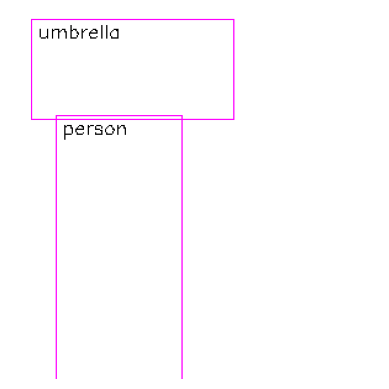

In [15]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
# draw a 31 x 31 empty grid
l = 300
grid = np.zeros((l, l, 3))
# draw the bounding box
x, y, w, h = query[1][query_idx]
x, y, w, h = l * x, l * y, l * w, l * h
x_min, y_min = int(x - w / 2), int(y - h / 2)
x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (0, 1, 0), 1)
text = f'{query[0][query_idx]}'
cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)


x, y, w, h = query[1][query_idx+1]
x, y, w, h = l * x, l * y, l * w, l * h
x_min, y_min = int(x - w / 2), int(y - h / 2)
x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (0, 1, 0), 1)
text = f'{query[0][query_idx+1]}'
cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)
grid = 1 - grid
# plt axis off
plt.axis('off')
plt.imshow(grid)


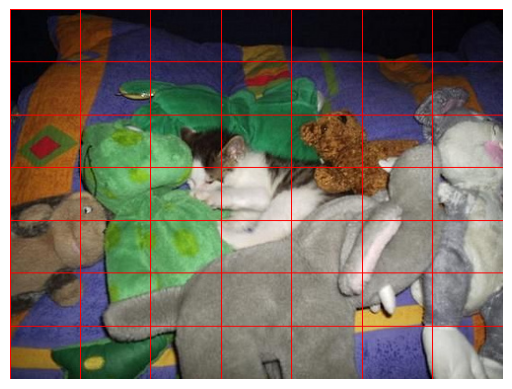

In [22]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
# img_path = f'./data/coco/val2017/images/000000{all_img_ids[indices[0][0]]:06}.jpg'
img_path = f'./data/coco/val2017/images/000000434996.jpg'

img = Image.open(img_path)
draw = ImageDraw.Draw(img)
width, height = img.size
x_spacing = width / 7
y_spacing = height / 7
for i in range(8):
    x = int(x_spacing * i)
    draw.line([(x, 0), (x, height)], fill='red')
for i in range(8):
    y = int(y_spacing * i)
    draw.line([(0, y), (width, y)], fill='red')

plt.imshow(img)
plt.axis('off')
plt.show()

In [110]:
import fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')


 (100.00%) [==================================================>]                                                 ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]>                                                  ]> 

In [114]:
cat_vec = ft_model.get_word_vector('baseball glove')
print(cat_vec.shape)

(300,)


In [9]:
output_feature = model(canvas_queries)
target_feature = backbone_model(imgs)

# Create a mask tensor for the entire batch
masks = torch.stack([create_bbox_mask(queries[1][i], 7) for i in range(BATCH_SIZE)]).to(device)
masks = masks.unsqueeze(1)  # Add channel dimension: [batch_size, 1, 7, 7]
# target_feature = target_feature * masks
# output_feature = output_feature * masks
# target_feature = target_feature.detach().cpu().numpy()
# output_feature = output_feature.detach().cpu().numpy()

: 

: 

In [69]:
# perform nearest neighbor search
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import numpy as np

query_ids = queries[3]
gt = np.array(queries[3])
# print(query_ids)
all_img_features = []

for i in range(output_feature.shape[0]):
    output = output_feature[i] * masks[i] # [2048, 7, 7]
    output = output.detach().cpu().numpy()
    target_list = []
    for j in range(target_feature.shape[0]):
        target = target_feature[j] * masks[j] # [2048, 7, 7]
        target = target.detach().cpu().numpy()
        # append each target with [2048, 7, 7] to the list to form [n, 2048, 7, 7]
        target_list.append(target)
    target_list = np.stack(target_list) # [n, 2048, 7, 7]
    target_list = target_list.reshape(target_list.shape[0], -1) # [n, 2048 * 49]
    # output = output.reshape(2048, 7, 7)
    # output = output.transpose(1, 2, 0)
    print(target_list.shape)
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine').fit(target_list) 
    distances, indices = nbrs.kneighbors(output.reshape(1, -1))
    print(indices)
# nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(target_list) 
# distances, indices = nbrs.kneighbors(output_feature) 
# indices = indices.reshape(-1)
# # print(indices)
# distances = distances.reshape(-1)
# query_ids = np.array(query_ids)
# query_ids = query_ids[indices]
# distances = distances[indices]

NameError: name 'output_feature' is not defined

In [21]:
import matplotlib.pyplot as plt
def visualize_sum(canvas_query):
    summed_image = canvas_query.sum(dim=0)
    print(summed_image.shape)
    summed_image = torch.ones((31, 31)) - summed_image
    # reverse the color channels
    # plot size is 10 inches by 10 inches
    plt.figure(figsize=(5, 5))
    plt.imshow(summed_image, cmap='gray')
    plt.title('Canvas Query')
    # plt.axis('off')
    plt.savefig('canvas_query.png')
    plt.show()

visualize_sum(masked_query)

TypeError: _sum() got an unexpected keyword argument 'dim'

[101891, 463176, 298347, 246181, 9296, 403074, 215863, 243464, 164093, 521184, 510756, 125394, 90509, 307794, 170888, 93411, 125639, 302108, 517031, 26981, 456190, 71159, 43936, 171012, 501388, 6847, 428412, 185302, 388398, 311583, 543836, 565227]
[101891 463176 298347 246181   9296 403074 215863 243464 164093 521184
 510756 125394  90509 307794 170888  93411  26981 302108 517031  26981
 125639  71159  43936 171012 501388 125639 428412 185302 388398 311583
 543836 565227]
[0.34850055 0.4426754  0.30742812 0.17858022 0.30294842 0.39514863
 0.5185952  0.46645612 0.37385654 0.35480124 0.35425705 0.27098495
 0.408351   0.35822737 0.40786642 0.29073745 0.4003206  0.36984205
 0.4001962  0.4003206  0.4003206  0.29262155 0.27247393 0.24923587
 0.39465564 0.4003206  0.4200325  0.27658623 0.37986732 0.3571996
 0.38396603 0.43802685]
num correct :  29
torch.Size([31, 31])


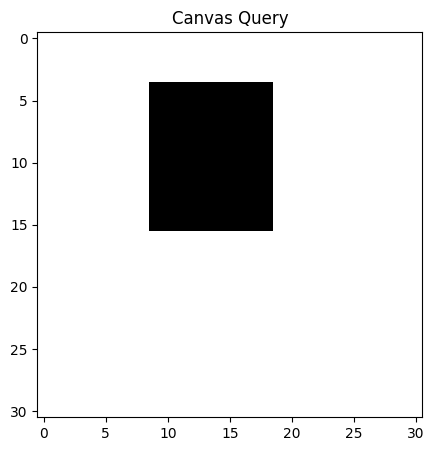

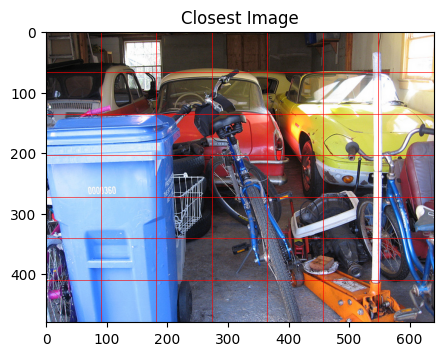

In [34]:
# perform nearest neighbor search
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import numpy as np

query_ids = queries[3]
gt = np.array(queries[3])
print(query_ids)
target_feature = target_feature.reshape(target_feature.shape[0], -1)
output_feature = output_feature.reshape(output_feature.shape[0], -1)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(target_feature)
distances, indices = nbrs.kneighbors(output_feature)
indices = indices.reshape(-1)
# print(indices)
distances = distances.reshape(-1)
query_ids = np.array(query_ids)
query_ids = query_ids[indices]
distances = distances[indices]
print(query_ids)
print(distances)
print('num correct : ', np.sum(query_ids == gt))
visualize_sum(canvas_queries[0].detach().cpu())
import os
image = Image.open(os.path.join(train_set.train_img_path, "{:012}".format(query_ids[0]) + '.jpg'))
#resize image to 31x31
# image = image.resize((31, 31))
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title('Closest Image')
# plt.axis('off')
plt.savefig('closest_image.png')
plt.show()

/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


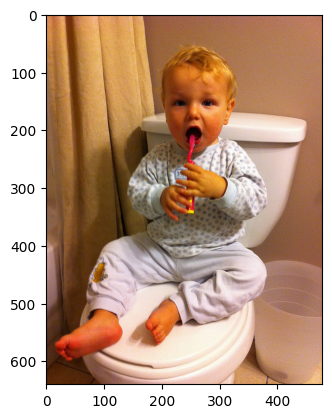

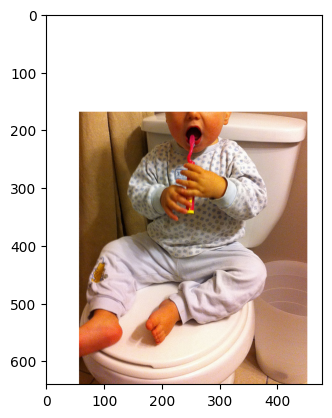

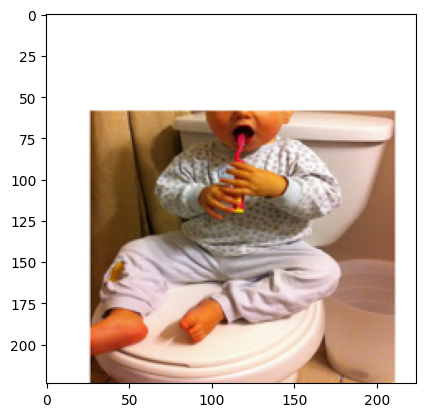

torch.Size([1, 2048, 7, 7])

In [45]:
from torchvision.models import resnet50
from PIL import Image, ImageDraw
import torch, torchvision
import matplotlib.pyplot as plt

model = resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-2]))
img_path = './data/coco/val2017/images/000000368212.jpg'
img = Image.open(img_path)
plt.imshow(img)
plt.show()
mask = Image.new('L', img.size, 0)
draw = ImageDraw.Draw(mask)
min_x, min_y, w, h = 57.97, 169.02, 392.72, 470.98
# min_x, min_y, w, h = 1.0, 1.0, 639.0, 417.96
# 57.97,
#                     169.02,
#                     392.72,
#                     470.98
max_x, max_y = min_x + w, min_y + h
draw.rectangle([min_x, min_y, max_x, max_y], fill=255)

result = Image.composite(img, Image.new('RGB', img.size, (255, 255, 255)), mask)
plt.imshow(result)
plt.show()
img = result.resize((224, 224))
plt.imshow(img)
plt.show()
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
model.eval()
pred = model(img_tensor.unsqueeze(0))
pred.shape

In [89]:
import json
query_path = './data/coco/train/query_.json'
with open(query_path, 'r') as f:
    query = json.load(f)
label_path = './data/coco/labels.txt'
with open(label_path, 'r') as f:
    labels = f.read().split('\n')

count_labels = {}
for q in query:
    label = q['layout']['category']
    if label not in count_labels:
        count_labels[label] = 0
    count_labels[label] += 1
print(count_labels)

{'dining table': 4017, 'teddy bear': 832, 'cake': 664, 'bench': 905, 'person': 24207, 'dog': 1137, 'clock': 219, 'motorcycle': 1085, 'bowl': 1060, 'broccoli': 455, 'chair': 1587, 'apple': 253, 'bed': 1455, 'backpack': 184, 'hot dog': 329, 'elephant': 1047, 'horse': 965, 'fork': 201, 'carrot': 203, 'couch': 1550, 'boat': 629, 'microwave': 123, 'cell phone': 219, 'train': 1398, 'bus': 1172, 'book': 476, 'pizza': 1162, 'knife': 223, 'orange': 314, 'sandwich': 845, 'bird': 560, 'airplane': 1043, 'snowboard': 139, 'tv': 625, 'keyboard': 293, 'mouse': 41, 'umbrella': 781, 'suitcase': 583, 'cat': 1386, 'car': 1058, 'banana': 648, 'cup': 419, 'giraffe': 1296, 'truck': 1017, 'oven': 563, 'potted plant': 522, 'tie': 219, 'bicycle': 482, 'baseball bat': 85, 'spoon': 123, 'zebra': 949, 'bottle': 319, 'surfboard': 375, 'skateboard': 179, 'vase': 405, 'traffic light': 79, 'laptop': 818, 'refrigerator': 640, 'wine glass': 236, 'sink': 360, 'toilet': 757, 'bear': 340, 'parking meter': 108, 'cow': 665,